In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pandas import DataFrame
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, log_loss
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Reshape, LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

import tensorflow as tf
print(f"Number of GPUs available : {len(tf.config.experimental.list_physical_devices('GPU'))} ")

Number of GPUs available : 1 


### Helper functions

In [2]:
def accumulateLogSum_noTarget(a,colname):
    row_sum = [] # Each element is sum (log(sum x))
    for _,row in a.iterrows(): # Sum all the columns for each row, each apply log to each element.
        row_s = 0
        for x in row:
            if x>0:
                row_s += np.log1p(x)
            elif x<0:
                row_s += -(np.log1p(-x))
            else:
                row_s += 0
        row_sum.append(row_s)
    col = DataFrame(row_sum,columns=[colname])
    return col

def getDF():
    dataframe = pd.read_csv('default of credit card clients.csv', encoding="utf-8", header=1)
    df = dataframe.copy(deep=True) # Make a deep copy so as not to modify the origional dataset
    df['EDUCATION'].loc[(df['EDUCATION'] > 4)] = 4
    df['EDUCATION'].loc[(df['EDUCATION'] == 0)] = 4
    df['MARRIAGE'].loc[(df['MARRIAGE'] >2)] = 3
    df['MARRIAGE'].loc[(df['MARRIAGE'] ==0)] = 3
    pay = df.iloc[:, 6:12]
    paydf = accumulateLogSum_noTarget(pay, 'PAY_LOGSUM')
    bill = df.iloc[:,12:18]
    billdf = accumulateLogSum_noTarget(bill, 'BILL_LOGSUM')
    payamt = df.iloc[:, 18:24]
    payamtdf = accumulateLogSum_noTarget(payamt, 'PAYAMT_LOGSUM')
    target_tmp = df.iloc[:,-1]
    firstcols = df.iloc[:,:6]
    newdf = pd.concat([firstcols,pay,paydf,bill,billdf,payamt,payamtdf,target_tmp], axis=1)
    x = newdf.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    newdf = pd.DataFrame(x_scaled)
    return newdf

def getPartialDF(dataframe, fraction):
    return dataframe.sample(frac=fraction, random_state=99)

def getSplit(dataframe, testsize):
    X = dataframe.iloc[:, 0:-1]
    y = dataframe.iloc[:,-1]
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=testsize )
    return x_train, x_test, y_train, y_test

def trainAndEvaluate(net):
    loss = 'binary_crossentropy'
    optimizer = 'adam'
    earlyStop = EarlyStopping(monitor='binary_accuracy', min_delta=0.05, patience=5, verbose=1)
    net = Model(inputs=net.inputs, outputs = net.outputs)
    net.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'])
    net.fit(x_train, y_train, batch_size=16, epochs=25, callbacks=earlyStop)
    _,acc = net.evaluate(x_test, y_test)
    print(f'Validation accuracy of model{acc*100}%')  

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Our Data

df : Our dataframe with added features from when we explored our data.

partialDF: 2500 random samples from our dataframe (df), used to train the models which take a really long time to compile.

In [3]:
df = getDF()
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.50000,0.159075,0.603733,0.280756,0.278633,0.249750,0.19833,0.186623,0.183380,0.177933,...,0.290851,0.785174,0.006483,0.003516,0.005832,0.007771,0.011252,0.009865,0.490336,0.221200
std,0.28869,0.131058,0.489129,0.248165,0.260702,0.158929,0.11238,0.119719,0.119687,0.116914,...,0.045766,0.138803,0.018961,0.013680,0.019650,0.025227,0.035820,0.033627,0.193008,0.415062
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.25000,0.040404,0.000000,0.000000,0.000000,0.120690,0.10000,0.100000,0.100000,0.100000,...,0.261944,0.721058,0.001145,0.000495,0.000435,0.000477,0.000592,0.000223,0.394309,0.000000
50%,0.50000,0.131313,1.000000,0.333333,0.500000,0.224138,0.20000,0.200000,0.200000,0.200000,...,0.274097,0.834652,0.002404,0.001193,0.002009,0.002415,0.003517,0.002837,0.543082,0.000000
75%,0.75000,0.232323,1.000000,0.333333,0.500000,0.344828,0.20000,0.200000,0.200000,0.200000,...,0.298787,0.881520,0.005731,0.002969,0.005028,0.006463,0.009452,0.007566,0.629867,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
partialDF = getPartialDF(df, 2500/30000)
partialDF.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.501339,0.162129,0.613600,0.291200,0.277000,0.248324,0.198720,0.184040,0.180160,0.176600,...,0.291439,0.780653,0.006665,0.003402,0.005643,0.007829,0.011328,0.009807,0.484794,0.220800
std,0.288166,0.135990,0.487021,0.255312,0.259996,0.156934,0.112336,0.121636,0.121903,0.121253,...,0.048349,0.147024,0.021145,0.010522,0.016415,0.023750,0.031904,0.038183,0.202398,0.414869
min,0.000700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.096670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.241391,0.040404,0.000000,0.000000,0.000000,0.120690,0.100000,0.100000,0.100000,0.100000,...,0.261902,0.720266,0.000893,0.000431,0.000435,0.000289,0.000451,0.000000,0.387565,0.000000
50%,0.503717,0.131313,1.000000,0.333333,0.500000,0.224138,0.200000,0.200000,0.200000,0.200000,...,0.274200,0.833794,0.002330,0.001216,0.002129,0.002412,0.003581,0.002837,0.540325,0.000000
75%,0.748383,0.232323,1.000000,0.333333,0.500000,0.344828,0.200000,0.200000,0.200000,0.200000,...,0.298673,0.881449,0.005725,0.002969,0.005025,0.006783,0.010084,0.007586,0.629323,0.000000
max,0.999900,0.747475,1.000000,1.000000,1.000000,0.827586,1.000000,0.900000,1.000000,1.000000,...,0.697967,0.983380,0.485264,0.228579,0.371422,0.534280,0.778376,0.837960,0.870909,1.000000


# Models and comparison

## Logistic regression

The model: Logistic regression which uses l2 penalties, since we want to maximally penalize false predictions. We don't need to worry about outlier values since we have a binomial target. Lbfgs solver gave the most consistent results during hyper-parameter tuning. 

The data: We use a random sample of the entire dataset, since training and evaluating on the dataset of 30000 datapoints with 24 features was demanding on my CPU for logistic regression.

Conclusions: The model obtains a mean cross-validation accuracy of 79.9% with std=0.01729. According to the confusion matrix, we can see that it often predicts no-default when there is in-fact a default. This suggests that the model is biased towards predicting no-default given a datapoint. Since 22% of target values are 'default' and 78% are 'no-default', a validation accuracy of 79.9% is not much better than naively predicting 'default' 22% of the time. This could be due to the fact that it is difficult to obtain complex relationships using logistic regression and linear decision boundaries.

Although we did not use the entire dataset for testing logistic regression, the evaluation on the partial dataset does not indicate that the model will perform particularly well on the dataset. Based on the 3D model of the PCA-reduced data, it seems as though k-nearest neighbour might perform better, since we observed that many datapoints with similar targets were close together.

In [26]:
x_train, x_test, y_train, y_test = getSplit(partialDF, 0.2)

In [27]:
lr = LogisticRegression(
    penalty='l2',  # Choose L2 loss since (ytrue-ypredicted)^2 will be small (binary)
    solver='lbfgs', # Gave best results while tuning
    tol=1e-4,
    random_state=24, 
    max_iter=15000,
    multi_class='multinomial', # Works well even for binary classes according to sklearn docs
    verbose=1,
    n_jobs=4 # 4-core PC
)
lr.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=15000,
                   multi_class='multinomial', n_jobs=4, penalty='l2',
                   random_state=24, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [28]:
cvs = cross_val_score(lr, x_train, y_train, cv=10)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   

In [29]:
print(cvs)
print(f'Mean cross validation accuracy: {100*np.mean(cvs):.4f} with std={cvs.std():.5f}')

[0.805 0.815 0.81  0.785 0.78  0.815 0.77  0.81  0.82  0.78 ]
Mean cross validation accuracy: 79.9000 with std=0.01729


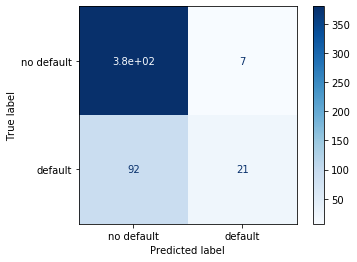

In [30]:
plot_confusion_matrix(lr, x_test, y_test, display_labels=['no default','default'], cmap=plt.cm.Blues )

## K-Nearest Neighbours

The model: We use k-nearest neighbours with k=30, as this returns the highest validation accuracy.

The data: We use a the full set of data since when evaluating the best value of k is affected by the number of samples in the data, we don't want to remove too many neighbours in the data.

Conclusions: Although KNN performs marginally better than logistic regression in this case (80.8% vs 79.9% mean cross validation accuracy), it suffers from a similar problem, as in it seems biased to predicting 'no-default'. It is also possible that the model performs better since it was trained on the entire dataset, rather than simply a sample, so a direct comparison may not be appropriate. 

Best value for k is : 30
KNN achieved a maximum validation accuracy of 0.8045
KNN achieved an average validation accuracy of 0.8001637426900584
KNN achieved a minimum log loss of 6.752465783904502
KNN achieved an average log loss of 6.9022388011725155


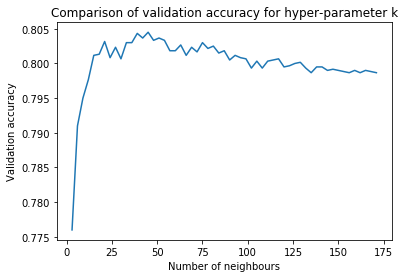

In [32]:
df = getDF()
x_train, x_test, y_train, y_test = getSplit(df, 0.2)

accuracies_mean, mean_log_losses = [],[] # Mean accuracy and mean log-loss for binary targets
neighbours = range(3, int(np.sqrt(len(df))), 3) # Generally want the value of k to be less than sqrt(n). Test k-values of multiples of 3.

for i in neighbours: # Iterate through all possible values of k we want to test
    accuracies_j, log_losses_j = [],[]  # Test K four times, get the mean validation accuracy of the 4 attempts
    for j  in range(3):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        accuracies_j.append(knn.score(x_test, y_test))
        log_losses_j.append(log_loss(knn.predict(x_test), np.array(y_test)))
    accuracies_mean.append(np.mean(accuracies_j))
    mean_log_losses.append(np.mean(log_losses_j))
    
best_k = 2*accuracies_mean.index(max(accuracies_mean))+2
plt.plot(neighbours, accuracies_mean)
plt.xlabel('Number of neighbours')
plt.ylabel('Validation accuracy')
plt.title('Comparison of validation accuracy for hyper-parameter k')
print(f'Best value for k is : {best_k}')
print(f'KNN achieved a maximum validation accuracy of {max(accuracies_mean)}')
print(f'KNN achieved an average validation accuracy of {np.mean(accuracies_mean)}')
print(f'KNN achieved a minimum log loss of {min(mean_log_losses)}')
print(f'KNN achieved an average log loss of {np.mean(mean_log_losses)}')

In [46]:
bestknn = KNeighborsClassifier(n_neighbors=best_k)
bestknn.fit(x_train,y_train)
cvs = cross_val_score(bestknn, x_train, y_train, cv=10)
print(cvs)
print(f'Mean cross validation accuracy: {100*np.mean(cvs):.4f} with std={cvs.std():.5f}')

[0.8075     0.80791667 0.8025     0.80208333 0.81083333 0.8075
 0.8125     0.81458333 0.80708333 0.80875   ]
Mean cross validation accuracy: 80.8125 with std=0.00372


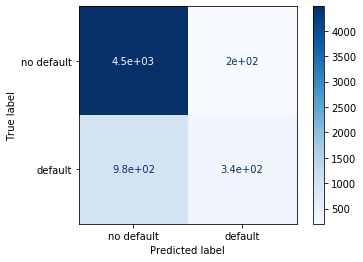

In [47]:
plot_confusion_matrix(bestknn, x_test, y_test, display_labels=['no default','default'], cmap=plt.cm.Blues )

## Kernel SVM

The model: A support vector machine with an 'rbf' kernel was used in binary classification for predicting defaulters.

The data: Although the fit time scales at-least quadratically with the number of features, we use the full dataset since the fit-time was only a few seconds.

Conclusions: It is the best performing 'simple' model tested. It has the highest mean cross-validation accuracy of 81.7%, however it still has trouble predicting which individuals will default. Now we must try more powerful predictive models.

In [48]:
df = getDF()
x_train, x_test, y_train, y_test = getSplit(df, 0.2)
svm = SVC(kernel="rbf")
svm.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
cvs = cross_val_score(svm, x_train, y_train, cv=10)

In [50]:
print(cvs)
print(f'Mean cross validation accuracy: {100*np.mean(cvs):.4f} with std={cvs.std():.5f}')

[0.82375    0.815      0.81583333 0.81458333 0.82333333 0.81541667
 0.81291667 0.81875    0.8175     0.81666667]
Mean cross validation accuracy: 81.7375 with std=0.00344


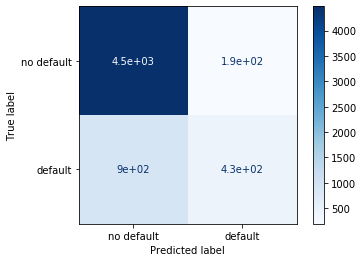

In [51]:
plot_confusion_matrix(svm, x_test, y_test, display_labels=['no default','default'], cmap=plt.cm.Blues )

## Deep Neural Networks

#### The models: 
We train 2 different neural networks. Both are variations from the top 2 neural networks from the NeuralTuner.ipnyb file. After manually tuning a dense neural network and a sparse neural network, it was found that the dense neural network generally performed better on the validation data than the sparse network and was faster to train. 

#### Dense neural network: 
The default ADAM learning rate of 0.001 was found to be the best learning rate. Sigmoid activation function in the final layer was also tested against tanh and softmax, and sigmoid performed the best. The hidden layer activation functions are all swish, which performed better than ReLU by almost 1%. The same applies for the sparse neural network. Batch normalization and dropout was also tuned after many attempts. It achieved a validation accuracy of 82%.

#### Sparse neural network: 
The default ADAM learning rate was found to be the best learning rate. Sigmoid activation function in the final layer was also tested against tanh and softmax, and sigmoid performed the best. As with the Dense neural network, swish gave higher validation accuracy than ReLu, and batch normalization and dropout was used to gain performance. It achieved a validation accuracy of 81.8%.

#### Things that didn't work: 
Kernel regularization gave poor results, models which had a large difference between the maximum number of neurons in the hidden layer and minimum number of neurons in the hidden layer also gave generally poor results. Randomsearch was used to find an initial model architecture, however manually creating coherent architectures gave networks which achieved higher validatin accuracy. SGD performed worse than ADAM by around 1-2%, so ADAM was used for all optimizers.

#### Conlcusions
The Dense neural network was the best performing model tested. It achieved a validation accuracy of 82%, maximum training accuracy of 80.9%. This suggests that it is neither overfitting, nor underfitting and is performing relatively well. As with all other models tested, it struggles with predicting 'defaults', but performs very well with predicting 'no default'.

## Sparse network

In [156]:
def createNeuralNet(): # Sparse
    model = Sequential()
    model.add(Dense(256, kernel_initializer='normal', input_dim = x_test.shape[1],activation='swish'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    
    model.add(Dense(256, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(512, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(512, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(512, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

net = createNeuralNet()
model = Model(inputs=net.inputs, outputs = net.outputs)
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy', # Choose this over hinge, since hinge is better for -1, 1
    metrics=['binary_accuracy'])
model.fit(x_train, y_train, batch_size=16, epochs=50, callbacks=earlyStop)
_,acc = model.evaluate(x_test, y_test)
print(f'Validation accuracy of model : {acc*100}%')

Epoch 1/50
1688/1688 [==============================] - 18s 10ms/step - loss: 0.5535 - binary_accuracy: 0.7481
Epoch 2/50
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4627 - binary_accuracy: 0.8054
Epoch 3/50
1688/1688 [==============================] - 16s 10ms/step - loss: 0.4620 - binary_accuracy: 0.8042
Epoch 4/50
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4610 - binary_accuracy: 0.8045
Epoch 5/50
1688/1688 [==============================] - 18s 10ms/step - loss: 0.4572 - binary_accuracy: 0.8067
Epoch 6/50
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4567 - binary_accuracy: 0.8071
Epoch 7/50
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4542 - binary_accuracy: 0.8134
Epoch 8/50
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4500 - binary_accuracy: 0.8107
Epoch 9/50
1688/1688 [==============================] - 19s 11ms/step - loss: 0.4500 - binary_accuracy: 0.8092
E

Confusion matrix, without normalization
[[2233   71]
 [ 539  157]]


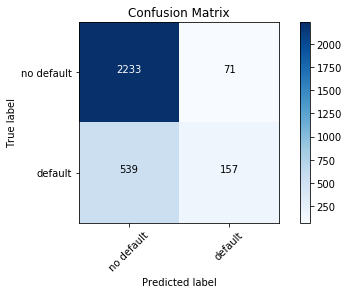

In [158]:
yt = y_test.to_numpy()
preds = np.round(model.predict(x_test))

cm = confusion_matrix(y_true=yt, y_pred=preds)
plot_confusion_matrix(cm=cm, classes=['no default','default'], title='Confusion Matrix')

## Dense network

Epoch 1/50
422/422 [==============================] - 4s 7ms/step - loss: 0.5864 - binary_accuracy: 0.7264
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4605 - binary_accuracy: 0.8086
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4459 - binary_accuracy: 0.8121
Epoch 4/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4458 - binary_accuracy: 0.8121
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4434 - binary_accuracy: 0.8148
Epoch 6/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4433 - binary_accuracy: 0.8112
Epoch 7/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4335 - binary_accuracy: 0.8170
Epoch 8/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4342 - binary_accuracy: 0.8167
Epoch 00008: early stopping
94/94 [==============================] - 0s 3ms/step - loss: 0.4438 - binary_accuracy: 0.8207
Validation accuracy of

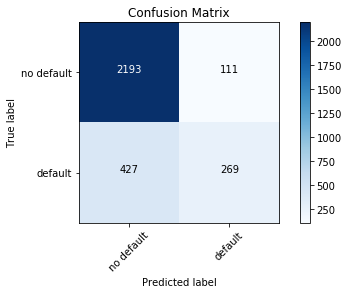

In [171]:
def createNeuralNet(): # Dense neural network
    model = Sequential()
    model.add(Dense(24, kernel_initializer='normal', input_dim = x_test.shape[1], activation='swish'))
    model.add(BatchNormalization())

    model.add(Dense(20, kernel_initializer='normal', activation='swish'))
    model.add(BatchNormalization())
    
    model.add(Dense(20, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

net = createNeuralNet()
model = Model(inputs=net.inputs, outputs = net.outputs)
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy', # Choose this over hinge, since hinge is better for -1, 1
    metrics=['binary_accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=50, callbacks=earlyStop)
_,acc = model.evaluate(x_test, y_test)
print(f'Validation accuracy of model : {acc*100}%')

yt = y_test.to_numpy()
preds = np.round(model.predict(x_test))

cm = confusion_matrix(y_true=yt, y_pred=preds)
plot_confusion_matrix(cm=cm, classes=['no default','default'], title='Confusion Matrix')

## So what did our model predict?

We will use the dense neural network to make a prediction on who is most likely to default in our test set, and who is least likely to default in our test set, and look at the features of that individual. We use the sparse neural network, since this was the network with the highest validation accuracy.

In [6]:
dataframe = pd.read_csv('default of credit card clients.csv', encoding="utf-8", header=1)
df = dataframe.copy(deep=True) # Make a deep copy so as not to modify the origional dataset
df['EDUCATION'].loc[(df['EDUCATION'] > 4)] = 4
df['EDUCATION'].loc[(df['EDUCATION'] == 0)] = 4
df['MARRIAGE'].loc[(df['MARRIAGE'] >2)] = 3
df['MARRIAGE'].loc[(df['MARRIAGE'] ==0)] = 3
pay = df.iloc[:, 6:12]
paydf = accumulateLogSum_noTarget(pay, 'PAY_LOGSUM')
bill = df.iloc[:,12:18]
billdf = accumulateLogSum_noTarget(bill, 'BILL_LOGSUM')
payamt = df.iloc[:, 18:24]
payamtdf = accumulateLogSum_noTarget(payamt, 'PAYAMT_LOGSUM')
target_tmp = df.iloc[:,-1]
firstcols = df.iloc[:,:6]
newdf = pd.concat([firstcols,pay,paydf,bill,billdf,payamt,payamtdf,target_tmp], axis=1)
x = newdf.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
newdf = pd.DataFrame(x_scaled)

X = newdf.iloc[:, 0:-1]
y = newdf.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )

earlyStop = EarlyStopping(monitor='binary_accuracy', min_delta=0.0075, patience=5, verbose=1)

def createNeuralNet(): # Dense neural network
    model = Sequential()
    model.add(Dense(24, kernel_initializer='normal', input_dim = x_test.shape[1], activation='swish'))
    model.add(BatchNormalization())

    model.add(Dense(20, kernel_initializer='normal', activation='swish'))
    model.add(BatchNormalization())
    
    model.add(Dense(20, kernel_initializer='normal', activation='swish'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

net = createNeuralNet()
model = Model(inputs=net.inputs, outputs = net.outputs)
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy', # Choose this over hinge, since hinge is better for -1, 1
    metrics=['binary_accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=50, callbacks=earlyStop)

Epoch 1/50
422/422 [==============================] - 4s 7ms/step - loss: 0.5886 - binary_accuracy: 0.7207
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4586 - binary_accuracy: 0.8112
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4506 - binary_accuracy: 0.8115
Epoch 4/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4468 - binary_accuracy: 0.8106
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4434 - binary_accuracy: 0.8166
Epoch 6/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4419 - binary_accuracy: 0.8160
Epoch 7/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4386 - binary_accuracy: 0.8153
Epoch 00007: early stopping


In [7]:
allrows = [row for row in x_test.iterrows()] # each row is a tuple(name which is some int, array of feature values)
allrows = [row[1] for row in allrows] # extract the feature values from each tuple in the list of all rows
allrows = [r.values.reshape(1,-1) for r in allrows] # turn each item into the shape which the model predicts in
allpredictions = [model.predict(r)[0][0] for r in allrows] # model.predict(r) returns [[prediction]], so extract the prediction

In [8]:
mostLikelyToDefault = max(allpredictions) # the model predicts with 97% certainty that this individual will default
leastLieklyToDefault = min(allpredictions) # the model predicts 

print(f'Individual who is most likely to default has a {mostLikelyToDefault*100:.4} percent chance of defaulting')
print(f'Individual who is least likely to default has a {leastLieklyToDefault*100:.4f} percent chance of defaulting')

Individual who is most likely to default has a 92.94 percent chance of defaulting
Individual who is least likely to default has a 0.0412 percent chance of defaulting


In [9]:
idxOfMax = allpredictions.index(max(allpredictions))
idxOfMin = allpredictions.index(min(allpredictions))

# These values are normalized, we need to use the scaler to give us the inverse transform
# Append a 0, just to make it compatable with minmaxsclaer. This "dummy column" is the target value which isn't in x_test
featuresOfMax = x_test.iloc[idxOfMax, :].append(pd.Series([0.], index=[27])).values.reshape(1,-1)
featuresOfMin = x_test.iloc[idxOfMin, :].append(pd.Series([0.], index=[27])).values.reshape(1,-1)

fmax = min_max_scaler.inverse_transform(featuresOfMax)
featuresMaxDefault = [int(i) for i in fmax[0]] # Extract the features from [[features]]

fmin = min_max_scaler.inverse_transform(featuresOfMin)
featuresMinDefault = [int(i) for i in fmin[0]]

print(featuresMaxDefault)
print(featuresMinDefault)
allfeatures = pd.concat([firstcols,pay,paydf,bill,billdf,payamt,payamtdf,target_tmp], axis=1).columns
print(allfeatures)
print(len(allfeatures))
print(len(featuresMinDefault))

[18868, 180000, 2, 2, 2, 28, 8, 7, 6, 4, 4, 2, 11, 197231, 194309, 189981, 185558, 181137, 184009, 72, 0, 0, 0, 0, 6000, 0, 8, 0]
[28717, 340000, 2, 1, 3, 42, -1, -1, -1, -1, -1, 0, -3, 139808, 176743, 34401, 205930, 265431, 270237, 71, 873552, 1215471, 889043, 621000, 20000, 145000, 76, 0]
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_LOGSUM', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'BILL_LOGSUM', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'PAYAMT_LOGSUM', 'default payment next month'],
      dtype='object')
28
28


In [10]:
print('Here are the featuers of an individual who is most likely to default, according to our model: ')
for i in range(len(allfeatures)):
    print(f'{allfeatures[i]} : {featuresMaxDefault[i]}')

Here are the featuers of an individual who is most likely to default, according to our model: 
ID : 18868
LIMIT_BAL : 180000
SEX : 2
EDUCATION : 2
MARRIAGE : 2
AGE : 28
PAY_0 : 8
PAY_2 : 7
PAY_3 : 6
PAY_4 : 4
PAY_5 : 4
PAY_6 : 2
PAY_LOGSUM : 11
BILL_AMT1 : 197231
BILL_AMT2 : 194309
BILL_AMT3 : 189981
BILL_AMT4 : 185558
BILL_AMT5 : 181137
BILL_AMT6 : 184009
BILL_LOGSUM : 72
PAY_AMT1 : 0
PAY_AMT2 : 0
PAY_AMT3 : 0
PAY_AMT4 : 0
PAY_AMT5 : 6000
PAY_AMT6 : 0
PAYAMT_LOGSUM : 8
default payment next month : 0


In [11]:
print('Here are the featuers of an individual who is least likely to default, according to our model: ')
for i in range(len(allfeatures)):
    print(f'{allfeatures[i]} : {featuresMinDefault[i]}')

Here are the featuers of an individual who is least likely to default, according to our model: 
ID : 28717
LIMIT_BAL : 340000
SEX : 2
EDUCATION : 1
MARRIAGE : 3
AGE : 42
PAY_0 : -1
PAY_2 : -1
PAY_3 : -1
PAY_4 : -1
PAY_5 : -1
PAY_6 : 0
PAY_LOGSUM : -3
BILL_AMT1 : 139808
BILL_AMT2 : 176743
BILL_AMT3 : 34401
BILL_AMT4 : 205930
BILL_AMT5 : 265431
BILL_AMT6 : 270237
BILL_LOGSUM : 71
PAY_AMT1 : 873552
PAY_AMT2 : 1215471
PAY_AMT3 : 889043
PAY_AMT4 : 621000
PAY_AMT5 : 20000
PAY_AMT6 : 145000
PAYAMT_LOGSUM : 76
default payment next month : 0


# Conclusion And Summary

## Models:

#### Logistic regression

Baseline model: 79.9% accuracy. Slow to train, underperforms.

#### K-Nearest Neighbours

80.8% accuracy, fast to train, simple.

#### SVM

Best performing 'simple' model, 81.7% accuracy.

#### Dense Neural Network

Best performing model overall, 82.1% accuracy but slow to train.

#### Sparse Neural Network

81.8% accuracy, but slowest to train.

#### Unsupervised learning

2D PCA-Reduced Data is unable to classify between the two target values, 3D appeared to show clusters, but no clustering method gave definitive results.

## Findings:

### Let's compare our pre-emptive data exploration with what our neural network has discovered.

#### Quantitative data

##### Paying and billing amounts: 
The individual who is least likely to default consistently has a high PAY_AMT, which suggests that the individual always pays back their bills is least likely to default. Furthermore, the payment amount AND billing amount is large, however when we look at the BILL_LOGSUM and PAY_LOGSUM, we see that they are roughly equal (payment slightly higher than billed). 

The individual who is most likely to default has several months with no payment whatsoever, with the exception of 1 small payment. Their sum of payments is much smaller than the sum of their billed amount. Infact, this individual has a very similar billing sum to the individual who consistently pays it off, however they do not pay their credit card bill.

This is something in which I did not discover in my pre-emptive data exploration by observing the charts and correlation matrix.

#### Payment timing
The individual who is least likely to default consistently pays duly. In the pre-emptive data exploration, I stated my hypothesis for this reason: the individual who is least likely to default has an automatic monthly payment system set-up, or has a routine habit of paying off their bills on a certain day of the month. 

The individual who is most likely to default is consistently *several* months late with their payment. At one point, the individual did not pay their credit card at all for 8 months.

This confirms my findings in the pre-emptive data exploration, which suggests that both the neural network model and I learned this feature correctly.

#### Age
The individual who is least likely to default is on the edge the range described in the data exploration. The age of the individual who is most likely to default is 28, which is well within the range of ages of an individual which, according to the pre-emptive data exploration, is most likely to default.

#### Qualitative data

It is difficult to say if qualitative data is an indicator of whether or not an individual is likely to default or not. Bayesian inference suggests that the probabilities of an individual defaulting changes with some of these qualities.

In this case, the individual who is least likely to default matches the qualitative features found in the pre-emptive data exploration. The same applies for the individual who is most likely to default, with the exception of education level, however a higher ratio of university graduates defaulted compared to individuals with highschool-level education, which I found to give the highest chance of defaulting.